In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from SPHERE.preprocess import *
from SPHERE.SPHERE import *
from SPHERE.utils import *
import numpy as np
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
random_seed = 2022
fix_seed(random_seed)

## Spatial ATAC

In [ ]:
adata = sc.read_h5ad('./mouse_embryo.h5ad')
mapping = {
    1: 'E15.5-S1',
    2: 'E15.5-S2',
    3: 'E13.5-S1',
    4: 'E13.5-S2',
    5: 'E12.5-S1',
    6: 'E12.5-S2'
}
adata.obs['slice_name'] = adata.obs['sample'].map(mapping)
slice_name_list = ['E15.5-S1', 'E15.5-S2', 'E13.5-S1', 'E13.5-S2', 'E12.5-S1', 'E12.5-S2']

In [3]:
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=int(0.01 * adata.shape[0]))
pca_feat(adata, n_comps=200)
adata.obsm['feat'] = adata.obsm['X_pca'].copy()

/home/yuzhuohan/workspace/ATAC/our/code_rep/SPHERE/preprocess.py:233: RuntimeWarning: divide by zero encountered in divide
  tf = X.multiply(1 / X.sum(axis=1))


In [4]:
adata = construct_neighbor_graph_inte(adata, slice_name_list)

In [5]:
batch_categories = np.unique(adata.obs['slice_name'])
batch_to_index = {batch: idx for idx, batch in enumerate(batch_categories)}
batch_indices = adata.obs['slice_name'].map(batch_to_index).values
num_batches = len(batch_categories)
batch_labels = np.eye(num_batches)[batch_indices]

In [6]:
model = SPHERE(adata, device=device, learning_rate=0.001, epochs=1200, dim_hid=64, 
               integrate=True, batch_label=batch_labels,slice_name_list = slice_name_list, pretrain=False,lambda_fea_recon=0.1,lambda_spa_recon=0.1,
               lambda_recon=4,lambda_con=0.5,lambda_align=15,lambda_latent=13)


/home/yuzhuohan/workspace/ATAC/our/code_rep/SPHERE/preprocess.py:148: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [7]:
output = model.train_inte()
adata.obsm['latent'] = output['latent']
adata.obsm['latent'] = pca(adata, use_reps='latent', n_comps=20)
sc.pp.neighbors(adata, use_rep='latent', n_neighbors=30)
sc.tl.umap(adata)

100%|██████████| 1200/1200 [05:18<00:00,  3.77it/s]


Model training finished!



/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=11, covariance_type='tied', random_state=0)
y = gm.fit_predict(adata.obsm['latent'], y=None)
adata.obs["leiden"] = pd.Series(y, index=adata.obs.index, dtype='category')

In [10]:
adata = sc.read_h5ad('/home/yuzhuohan/workspace/ATAC/our/embyro/final/best_0.42_0.23_0.45/final_inte.h5ad')
sc.pp.neighbors(adata, n_neighbors=30, use_rep='emb_latent_pca')
sc.tl.umap(adata)

In [12]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata.obs['leiden'], adata.obs['clusters']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata.obs['leiden'], adata.obs['clusters']), 2)
HS = np.round(metrics.homogeneity_score(adata.obs['leiden'], adata.obs['clusters']), 2)
print(NMI)
print(ARI)
print(HS)

0.42
0.23
0.45


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


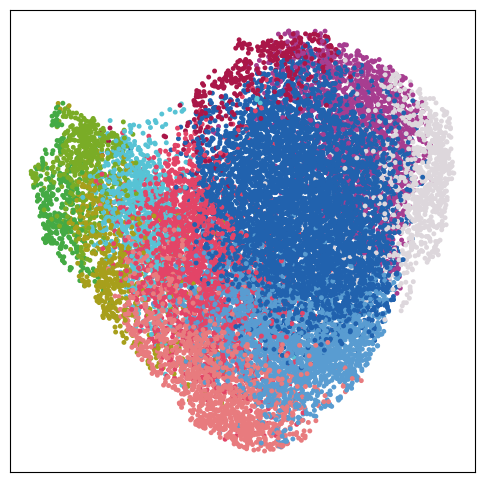

In [ ]:
# domain
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
plot_color=["#E87B7E","#2162AE","#57C3D5","#DDD7DC","#AA1648","#A73D90",
        "#7AAC26","#A79F1B","#599CD1","#E34467","#44AA44"]
fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["leiden"],
    s=50,
    show=False,
    palette=plot_color,
    legend_loc=None,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("") 
ax.set_ylabel("")

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


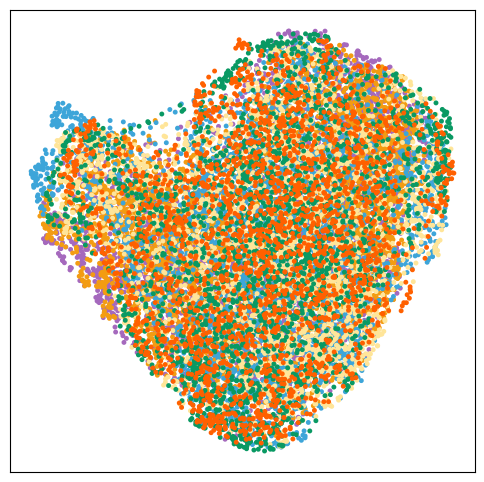

In [ ]:
# batch
plt.rcParams["figure.figsize"] = (6, 6)
plot_color=["#099963","#FF6000","#3DA5D9","#FFE599","#A569BD","#F39C12"]
fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["slice_name"],
    s=50,
    show=False,
    palette=plot_color,
    legend_loc=None,
    ax=ax
)  
ax.set_title("")  
ax.set_xlabel("")  
ax.set_ylabel("")

In [16]:
plot_color=["#44AA44","#E34467","#599CD1","#A73D90","#AA1648","#E87B7E",
        "#DDD7DC","#A79F1B","#7AAC26","#57C3D5","#2162AE"]
leiden_categories = [str(i) for i in range(11)]  
leiden_color_map = dict(zip(leiden_categories, plot_color))

## E12.5-S1

0.45
0.28
0.49


/tmp/ipykernel_3542813/2398108298.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

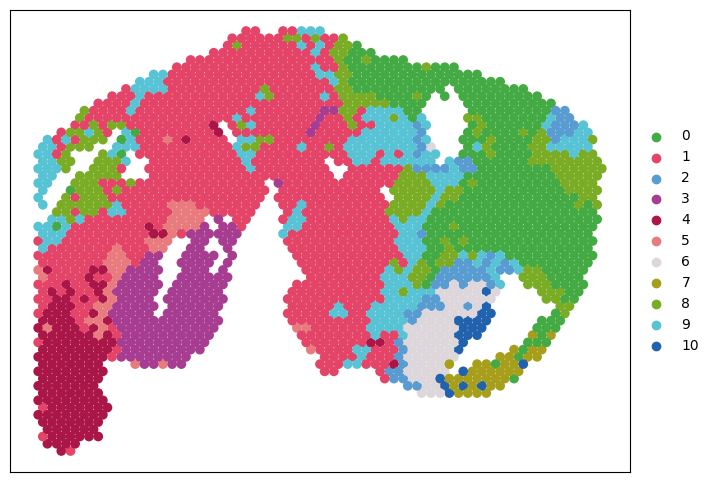

In [18]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[4]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=195,
    show=False,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  

## E12.5-S2

0.4
0.22
0.46


/tmp/ipykernel_3542813/810873129.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

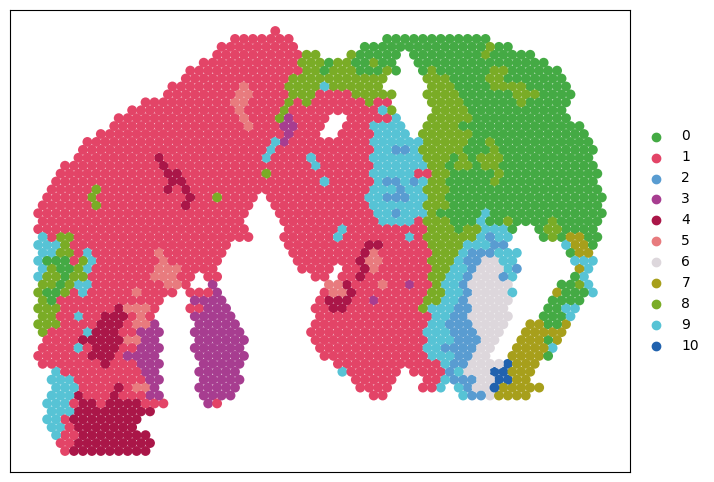

In [19]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[5]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=200,
    show=False,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  

## E13.5-S1

0.45
0.26
0.49


/tmp/ipykernel_3542813/392751369.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

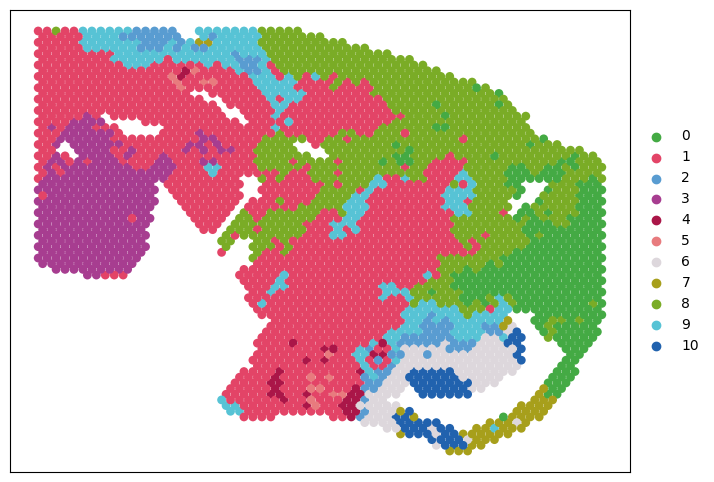

In [20]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[2]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=160,
    show=False,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  

## E13.5-S2

0.45
0.27
0.51


/tmp/ipykernel_3542813/387466563.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

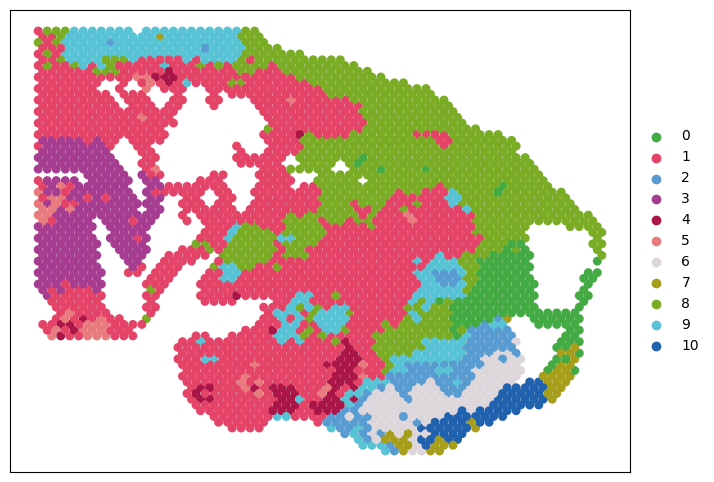

In [21]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[3]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=165,
    show=False,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  

## E15.5-S1

/tmp/ipykernel_3542813/2527409237.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors


0.45
0.35
0.47


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

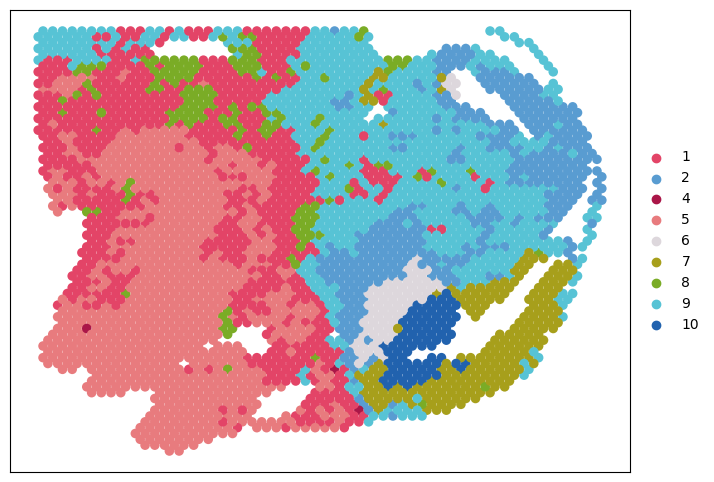

In [22]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[0]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=190,
    show=False,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  

## E15.5-S2

/tmp/ipykernel_3542813/1574884900.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors


0.41
0.31
0.43


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

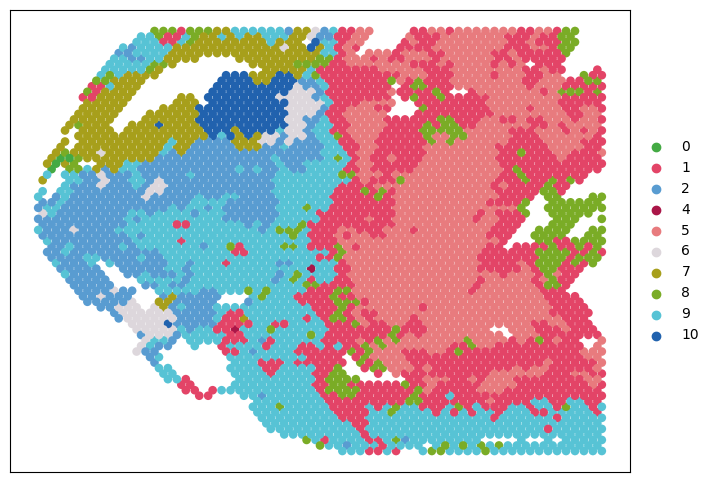

In [23]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[1]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['clusters']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=155,
    show=False,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  